In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.layers.pooling import MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from keras.models import Model

# VGG16

In [3]:
BATCH_SIZE = 64
img_height = 224
img_width = 224

# Data Augmentation

In [4]:
from keras.applications.vgg16 import VGG16, preprocess_input
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=20, 
                                     brightness_range=[0.1, 1.0],
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1,
                                     horizontal_flip=True, 
                                    #  shear_range = 0.2,
                                     zoom_range = [0.2,1],
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input)

In [5]:
train_data_dir = '/kaggle/input/car-train/train'
test_data_dir = '/kaggle/input/car-valid/valid'

In [6]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE, )

validgen = test_generator.flow_from_directory(test_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,)

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [7]:
num_classes = traingen.num_classes
num_classes

196

# Model

In [41]:
def vgg_fine_tune(base_model,num_classes,dropout):
#     base_model.summary()
    base_model.trainable = True
    for _i, _layer in enumerate(base_model.layers):
        if _i < 15:
            _layer.trainable = False
        else:
            _layer.trainable = True
    
    x = base_model.output
    x = layers.Dense(512, activation='relu')(x)
    x = GlobalAveragePooling2D()(x) 

    predictions = layers.Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.summary()
    return model

In [42]:
HEIGHT = 224
WIDTH = 224
dropout = 0.7
input_shape=(HEIGHT, WIDTH, 3)
lr = 0.0001
epochs=100
vgg_base_model = VGG16(input_shape = input_shape,weights='imagenet',include_top = False)
vgg_model = vgg_fine_tune(vgg_base_model,num_classes,dropout=dropout)
vgg_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [10]:
train_steps = len(traingen.filenames) // BATCH_SIZE
validation_steps = len(validgen.filenames) // BATCH_SIZE

In [11]:
print(train_steps)
print(validation_steps)

101
25


In [43]:
history = vgg_model.fit_generator(
    traingen,
    validation_data = validgen,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_steps=validation_steps
#     callbacks = [callback]
)

Epoch 1/100
101/101 [==============================] - 173s 2s/step - loss: 5.2881 - accuracy: 0.0059 - val_loss: 5.2781 - val_accuracy: 0.0044
Epoch 2/100
101/101 [==============================] - 172s 2s/step - loss: 5.2767 - accuracy: 0.0074 - val_loss: 5.2704 - val_accuracy: 0.0050
Epoch 3/100
101/101 [==============================] - 172s 2s/step - loss: 5.2561 - accuracy: 0.0115 - val_loss: 5.2528 - val_accuracy: 0.0075
Epoch 4/100
101/101 [==============================] - 173s 2s/step - loss: 5.2107 - accuracy: 0.0150 - val_loss: 5.1711 - val_accuracy: 0.0200
Epoch 5/100
101/101 [==============================] - 175s 2s/step - loss: 5.0985 - accuracy: 0.0209 - val_loss: 5.2326 - val_accuracy: 0.0294
Epoch 6/100
101/101 [==============================] - 174s 2s/step - loss: 4.9618 - accuracy: 0.0326 - val_loss: 4.8924 - val_accuracy: 0.0419
Epoch 7/100
101/101 [==============================] - 173s 2s/step - loss: 4.8217 - accuracy: 0.0405 - val_loss: 4.6071 - val_accuracy:

In [17]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'][1:])
    plt.plot(history.history['val_accuracy'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

# Saving model

In [44]:
vgg_model.save('vgg_model.h5')

In [45]:
validation_score = vgg_model.evaluate_generator(validgen, steps=validation_steps)
print('Validation loss: ', validation_score[0])
print('Validation acc:  ', validation_score[1])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation loss:  1.6426937580108643
Validation acc:   0.6575000286102295


# Plotting accuracy and loss

In [46]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'][1:])
    plt.plot(history.history['val_accuracy'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

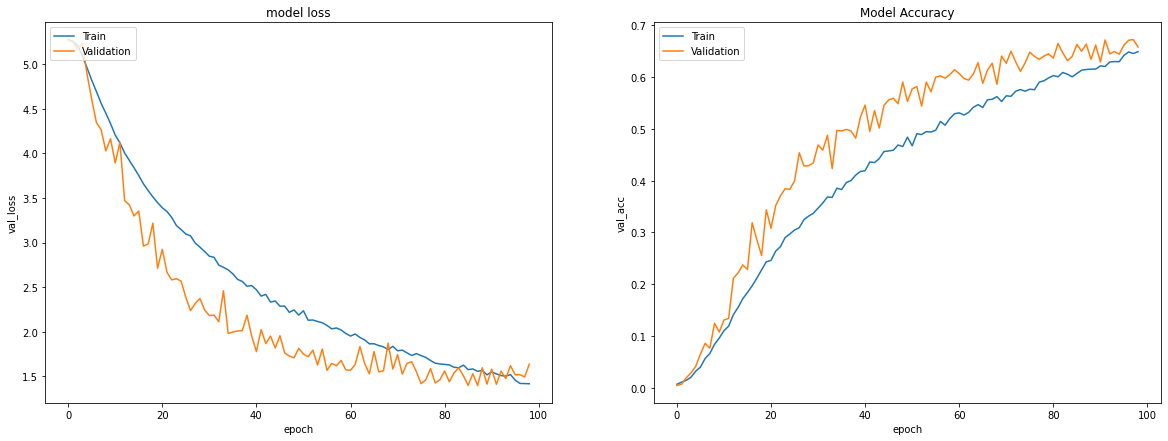

In [47]:
plot_loss_acc(history)

# InceptionV3

In [5]:
def fine_tune(base_model,num_classes,dropout):
#     base_model.summary()
#     for layer in base_model.layers:
#         layer.trainable = False
    x=base_model.output
    x = AveragePooling2D((5, 5), name='avg_pool')(x)
    x = Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)

    predictions = layers.Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
#     model.summary()
    return model

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
HEIGHT = 299
WIDTH = 299

input_shape=(HEIGHT, WIDTH, 3)

lr = 0.0001
dropout = 0.7
epochs = 50

base_model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

model = fine_tune(base_model,num_classes,dropout=dropout)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


2023-02-09 13:21:26.594701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 13:21:26.693071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 13:21:26.693976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 13:21:26.695759: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


In [6]:
from keras.applications.inception_v3 import preprocess_input
train_generator = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=20, 
                                     brightness_range=[0.1, 1.0],
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1,
                                     horizontal_flip=True, 
                                    #  shear_range = 0.2,
                                     zoom_range = [0.2,1],
                                     preprocessing_function=preprocess_input
                                     ) 

test_generator = ImageDataGenerator(rescale=1.0/255,
                                    preprocessing_function=preprocess_input
                                    )

In [7]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE, )

validgen = test_generator.flow_from_directory(test_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,)

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [8]:
num_classes = traingen.num_classes
num_classes

196

In [12]:
inc_history = model.fit_generator(generator=traingen,
                                        validation_data=validgen,
                                        steps_per_epoch=train_steps,
                                        epochs=100,verbose=2,validation_steps=validation_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-09 13:22:01.348434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-09 13:22:15.137698: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


101/101 - 226s - loss: 5.3016 - accuracy: 0.0057 - val_loss: 5.2915 - val_accuracy: 0.0056
Epoch 2/100
101/101 - 173s - loss: 5.2182 - accuracy: 0.0140 - val_loss: 5.2761 - val_accuracy: 0.0069
Epoch 3/100
101/101 - 170s - loss: 5.0653 - accuracy: 0.0271 - val_loss: 5.1009 - val_accuracy: 0.0312
Epoch 4/100
101/101 - 171s - loss: 4.8499 - accuracy: 0.0439 - val_loss: 4.5875 - val_accuracy: 0.0781
Epoch 5/100
101/101 - 170s - loss: 4.5692 - accuracy: 0.0685 - val_loss: 4.1702 - val_accuracy: 0.1112
Epoch 6/100
101/101 - 170s - loss: 4.2450 - accuracy: 0.1090 - val_loss: 3.7610 - val_accuracy: 0.1838
Epoch 7/100
101/101 - 171s - loss: 3.8806 - accuracy: 0.1510 - val_loss: 3.2010 - val_accuracy: 0.2587
Epoch 8/100
101/101 - 171s - loss: 3.5311 - accuracy: 0.2015 - val_loss: 2.8398 - val_accuracy: 0.3081
Epoch 9/100
101/101 - 172s - loss: 3.1942 - accuracy: 0.2590 - val_loss: 2.4826 - val_accuracy: 0.3994
Epoch 10/100
101/101 - 171s - loss: 2.9023 - accuracy: 0.3027 - val_loss: 2.3880 - va

In [13]:
model.save('inception_model.h5')

In [15]:
validation_score = model.evaluate_generator(validgen, steps=validation_steps)
print('Validation loss: ', validation_score[0])
print('Validation acc:  ', validation_score[1])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation loss:  2.0542314052581787
Validation acc:   0.6850000023841858


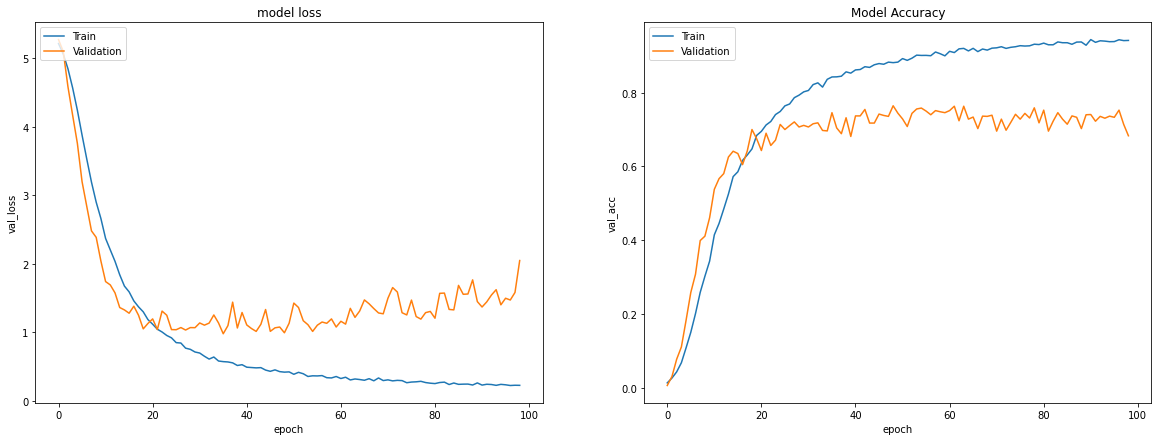

In [18]:
plot_loss_acc(inc_history)